In [2]:
import gc
import os
import cv2
import glob
import sys
import torch
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *
import pycocotools.mask as mask_util
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling.meta_arch.rcnn import GeneralizedRCNN
from detectron2.layers import ShapeSpec
from detectron2.modeling import build_proposal_generator, build_roi_heads
import detectron2.data.transforms as T
import segmentation_models_pytorch as smp
from torchvision.models.detection.backbone_utils import FeaturePyramidNetwork, LastLevelMaxPool
import torch
from torch import nn
from torchvision.ops import misc as misc_nn_ops
import torchvision
from detectron2.layers.batch_norm import FrozenBatchNorm2d

sys.path.append('../input/resnest/d2')
sys.path.append('../input/resnest/detectron2_resnest')
sys.path.append('../input/detectron-swin/swin')
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

In [3]:
from d2 import add_resnest_config
from detectron2_resnest.modeling import build_model
from src.swin.swint import add_swinl_384_config

In [4]:
dataDir=Path('../input/sartorius-cell-instance-segmentation')

register_coco_instances('sartorius_val_fold_1',{},'../input/5-fold-x-152/5_fold_split_sartorius_coco_dataset/annotations_val_fold_1.json', dataDir)
register_coco_instances('sartorius_val_fold_2',{},'../input/5-fold-x-152/5_fold_split_sartorius_coco_dataset/annotations_val_fold_2.json', dataDir)
register_coco_instances('sartorius_val_fold_3',{},'../input/5-fold-x-152/5_fold_split_sartorius_coco_dataset/annotations_val_fold_3.json', dataDir)
register_coco_instances('sartorius_val_fold_4',{},'../input/5-fold-x-152/5_fold_split_sartorius_coco_dataset/annotations_val_fold_4.json', dataDir)
register_coco_instances('sartorius_val_fold_5',{},'../input/5-fold-x-152/5_fold_split_sartorius_coco_dataset/annotations_val_fold_5.json', dataDir)
val_ds1 = DatasetCatalog.get('sartorius_val_fold_1')
val_ds2 = DatasetCatalog.get('sartorius_val_fold_2')
val_ds3 = DatasetCatalog.get('sartorius_val_fold_3')
val_ds4 = DatasetCatalog.get('sartorius_val_fold_4')
val_ds5 = DatasetCatalog.get('sartorius_val_fold_5')
val_dss = [val_ds1, val_ds2, val_ds3, val_ds4, val_ds5]

CFG_X152 = "Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml"
X152_WEIGHTS = [f'../input/sartorius-cascade-x152/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv_best_{fold_idx}.pth' for fold_idx in range(1,6)]

CFG_RS200 = "../input/resnest/resnest_configs/resnest_configs/COCO-InstanceSegmentation/mask_cascade_rcnn_ResNeSt_200_FPN_syncBN_all_tricks_3x.yaml"
RS200_WEIGHTS = [f'../input/resnest200-5folds-3classes/resnest200_f{fold_idx}.pth' for fold_idx in range(1,6)]

CFG_SWINL = "../input/detectron-swin/configs/configs/SwinT/mask_rcnn_swint_T_FPN_3x.yaml"
SWIN_WEIGHTS = [f'../input/detectron2-swint-l/mask_rcnn_swint_L_FPN_3x_best_{fold_idx}.pth' for fold_idx in range(1,6)]

best_models = (
    {'file': RS200_WEIGHTS[0], 'config_name': CFG_RS200, 'LB score': 0.3,'ths': [0.3, 0.375, 0.675], 'pxls': [70, 100, 100], 'iou_th': 0.325, 'mask_weight': 1, 'v_flip': False, 'h_flip': False},
    {'file': RS200_WEIGHTS[1], 'config_name': CFG_RS200, 'LB score': 0.3,'ths': [0.3, 0.375, 0.675], 'pxls': [70, 100, 100], 'iou_th': 0.325, 'mask_weight': 1, 'v_flip': False, 'h_flip': False},
    {'file': RS200_WEIGHTS[2], 'config_name': CFG_RS200, 'LB score': 0.3,'ths': [0.3, 0.375, 0.675], 'pxls': [70, 100, 100], 'iou_th': 0.325, 'mask_weight': 1, 'v_flip': False, 'h_flip': False},
    {'file': RS200_WEIGHTS[3], 'config_name': CFG_RS200, 'LB score': 0.3,'ths': [0.3, 0.375, 0.675], 'pxls': [70, 100, 100], 'iou_th': 0.325, 'mask_weight': 1, 'v_flip': False, 'h_flip': False},
    {'file': RS200_WEIGHTS[4], 'config_name': CFG_RS200, 'LB score': 0.3,'ths': [0.3, 0.375, 0.675], 'pxls': [70, 100, 100], 'iou_th': 0.325, 'mask_weight': 1, 'v_flip': False, 'h_flip': False},
    {'file': SWIN_WEIGHTS[0], 'config_name': CFG_SWINL, 'LB score': 0.3,'ths': [0.275, 0.5, 0.775], 'pxls': [80, 170, 60], 'iou_th': 0.25, 'mask_weight': 1, 'v_flip': False, 'h_flip': False},
    {'file': SWIN_WEIGHTS[1], 'config_name': CFG_SWINL, 'LB score': 0.3,'ths': [0.275, 0.5, 0.775], 'pxls': [80, 170, 60], 'iou_th': 0.25, 'mask_weight': 1, 'v_flip': False, 'h_flip': False},
    {'file': SWIN_WEIGHTS[2], 'config_name': CFG_SWINL, 'LB score': 0.3,'ths': [0.275, 0.5, 0.775], 'pxls': [80, 170, 60], 'iou_th': 0.25, 'mask_weight': 1, 'v_flip': False, 'h_flip': False},
    {'file': SWIN_WEIGHTS[3], 'config_name': CFG_SWINL, 'LB score': 0.3,'ths': [0.275, 0.5, 0.775], 'pxls': [80, 170, 60], 'iou_th': 0.25, 'mask_weight': 1, 'v_flip': False, 'h_flip': False},
    {'file': SWIN_WEIGHTS[4], 'config_name': CFG_SWINL, 'LB score': 0.3,'ths': [0.275, 0.5, 0.775], 'pxls': [80, 170, 60], 'iou_th': 0.25, 'mask_weight': 1, 'v_flip': False, 'h_flip': False},
)

NMS_TH = 0.25
AVG_TH = 0.5

AVERAGE_MASKS = True
JOIN_SUPPRESSED = True
KEEP_SUP_THR = 0.95

MODEL_WEIGHTS = None

test_files = glob.glob('../input/sartorius-cell-instance-segmentation/test/*')

# Utils

In [5]:
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def get_masks(fn, predictor, idx=0):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_classes = pred['instances'].pred_classes.cpu().numpy().tolist()
    pred_class = max(set(pred_classes), key=pred_classes.count)
    
    take = pred['instances'].scores >= best_models[idx]['ths'][pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int) 
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= best_models[idx]['pxls'][pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

In [6]:
def prepare_boxes(boxes, scores, labels, model_idxs):
    result_boxes = boxes.copy()
    cond = (result_boxes < 0)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Fixed {} boxes coordinates < 0'.format(cond_sum))
        result_boxes[cond] = 0
    cond = (result_boxes > 1)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Fixed {} boxes coordinates > 1. Check that your boxes was normalized at [0, 1]'.format(cond_sum))
        print(result_boxes[cond])
        result_boxes[cond] = 1
    boxes1 = result_boxes.copy()
    result_boxes[:, 0] = np.min(boxes1[:, [0, 2]], axis=1)
    result_boxes[:, 2] = np.max(boxes1[:, [0, 2]], axis=1)
    result_boxes[:, 1] = np.min(boxes1[:, [1, 3]], axis=1)
    result_boxes[:, 3] = np.max(boxes1[:, [1, 3]], axis=1)
    area = (result_boxes[:, 2] - result_boxes[:, 0]) * (result_boxes[:, 3] - result_boxes[:, 1])
    cond = (area == 0)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Removed {} boxes with zero area!'.format(cond_sum))
        result_boxes = result_boxes[area > 0]
        scores = scores[area > 0]
        labels = labels[area > 0]
        model_idxs = model_idxs[area > 0]
    return result_boxes, scores, labels, model_idxs

In [7]:
def nms_float_fast(dets, scores, model_idxs):
    """
    # It's different from original nms because we have float coordinates on range [0; 1]
    :param dets: numpy array of boxes with shape: (N, 5). Order: x1, y1, x2, y2, score. All variables in range [0; 1]
    :param thresh: IoU value for boxes
    :return: index of boxes to keep
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    supressed_list = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= best_models[model_idxs[i]]['iou_th'])[0]
        supressed = np.where(ovr > KEEP_SUP_THR)[0].copy()
        supressed_list.append(order[supressed + 1].copy())
        order = order[inds + 1]
    return keep, supressed_list

In [8]:
def nms_method(boxes, scores, labels, model_idxs, weights=None):
    # If weights are specified
    if weights is not None:
        if len(boxes) != len(weights):
            print('Incorrect number of weights: {}. Must be: {}. Skip it'.format(len(weights), len(boxes)))
        else:
            weights = np.array(weights)
            for i in range(len(weights)):
                scores[i] = (np.array(scores[i]) * weights[i]) / weights.sum()

    # We concatenate everything
    boxes = np.concatenate(boxes)
    scores = np.concatenate(scores)
    labels = np.concatenate(labels)
    model_idxs = np.concatenate(model_idxs)

    # Fix coordinates and removed zero area boxes
    boxes, scores, labels, model_idxs = prepare_boxes(boxes, scores, labels, model_idxs)

    # Run NMS independently for each label
    unique_labels = np.unique(labels)
    final_boxes = []
    final_scores = []
    final_labels = []
    final_supressed = []
    final_model_idxs = []
    for l in unique_labels:
        condition = (labels == l)
        boxes_by_label = boxes[condition]
        scores_by_label = scores[condition]
        model_idxs_by_label = model_idxs[condition]
        labels_by_label = np.array([l] * len(boxes_by_label))

        keep, supressed = nms_float_fast(boxes_by_label, scores_by_label, model_idxs_by_label)

        final_boxes.append(boxes_by_label[keep])
        final_scores.append(scores_by_label[keep])
        final_model_idxs.append(model_idxs_by_label[keep])
        final_labels.append(labels_by_label[keep])
        final_supressed.append(supressed)
    final_boxes = np.concatenate(final_boxes)
    final_scores = np.concatenate(final_scores)
    final_model_idxs = np.concatenate(final_model_idxs)
    final_labels = np.concatenate(final_labels)

    return final_boxes, final_scores, final_labels, final_supressed, final_model_idxs

def nms(boxes, scores, labels, model_idxs, weights=None):
    return nms_method(boxes, scores, labels, model_idxs, weights=weights)

In [9]:
def ensemble_preds(file_name, models):
    img = cv2.imread(file_name)
    height, width = img.shape[: 2]
    classes = []
    scores = []
    bboxes = []
    masks = []
    model_idxs = []
    for i, model in enumerate(models):
        output = model(img)
        pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
        pred_class = max(set(pred_classes), key=pred_classes.count)
        take = output['instances'].scores >= best_models[i]['ths'][pred_class]
        # fix predicted classes to a single class
        # otherwise NMS will work incorrectly, because it works each class separately
        pred_classes = output['instances'].pred_classes[take].cpu().numpy().tolist()
        pred_classes = [pred_class] * len(pred_classes)
        classes.extend(pred_classes)
        
        scores.extend(output['instances'].scores[take].cpu().numpy().tolist())
        bboxes.extend(output['instances'].pred_boxes[take].tensor.cpu().numpy().tolist())
        masks.extend(output['instances'].pred_masks[take].cpu().numpy())
        
        model_idxs.extend([i for _ in range(len(pred_classes))])
        
        h_flip = best_models[i]['h_flip']
        v_flip = best_models[i]['v_flip']
        
        if (h_flip):
            img2 = cv2.flip(img, 1)
            output = model(img2)
            pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
            pred_class = max(set(pred_classes), key=pred_classes.count)
            take = output['instances'].scores >= best_models[i]['ths'][pred_class]
            # fix predicted classes to a single one
            # otherwise NMS will crash, because it works each class separately
            pred_classes = output['instances'].pred_classes[take].cpu().numpy().tolist()
            pred_classes = [pred_class] * len(pred_classes)
            classes.extend(pred_classes)
        
            scores.extend(output['instances'].scores[take].cpu().numpy().tolist())
            boxes = output['instances'].pred_boxes[take].tensor.cpu().numpy()
            # flip boxes and masks
            boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
            bboxes.extend(boxes.tolist())
            pred_masks = output['instances'].pred_masks[take].cpu().numpy()
            for j in range(pred_masks.shape[0]):
                pred_masks[j] = np.fliplr(pred_masks[j])
            masks.extend(pred_masks)
            print('Hor. flipped predicted mask number:', pred_masks.shape[0])
            
            model_idxs.extend([i for _ in range(len(pred_classes))])

        if (v_flip):
            img2 = cv2.flip(img, 0)
            output = model(img2)
            pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
            pred_class = max(set(pred_classes), key=pred_classes.count)
            take = output['instances'].scores >= best_models[i]['ths'][pred_class]
            # fix predicted classes to a single one
            # otherwise NMS will crash, because it works each class separately
            pred_classes = output['instances'].pred_classes[take].cpu().numpy().tolist()
            pred_classes = [pred_class] * len(pred_classes)
            classes.extend(pred_classes)
        
            scores.extend(output['instances'].scores[take].cpu().numpy().tolist())
            boxes = output['instances'].pred_boxes[take].tensor.cpu().numpy()
            # flip boxes and masks
            boxes[:, [1, 3]] = height - boxes[:, [3, 1]]
            bboxes.extend(boxes.tolist())
            pred_masks = output['instances'].pred_masks[take].cpu().numpy()
            for j in range(pred_masks.shape[0]):
                pred_masks[j] = np.flipud(pred_masks[j])
            masks.extend(pred_masks)
            print('Ver. flipped predicted mask number:', pred_masks.shape[0])
            
            model_idxs.extend([i for _ in range(len(pred_classes))])
        del output
        torch.cuda.empty_cache()
        gc.collect()
    assert len(classes) == len(masks) , 'ensemble lenght mismatch'
    return classes, scores, bboxes, masks, model_idxs

In [10]:
def nms_predictions(classes, scores, bboxes, masks, model_idxs, nms_th=NMS_TH, shape=(520, 704)): # model_idxs
    he, wd = shape[0], shape[1]
    boxes_list = [[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he] for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    nms_bboxes, nms_scores, nms_classes, sup_list, model_idxs_keep = nms([boxes_list], [scores_list], [labels_list], [model_idxs], weights=MODEL_WEIGHTS)
    nms_scores = list(filter(lambda score: score >= nms_th, nms_scores))
    nms_masks = []
    sup_list = sup_list[0]
    for i, s in enumerate(nms_scores):
        current_mask = masks[scores.index(s)]
        if JOIN_SUPPRESSED and i < len(sup_list):
            if AVERAGE_MASKS:
                current_mask = current_mask.astype(float)
                total_masks = 1
                for j in sup_list[i]:
                    mask_weight = best_models[model_idxs[j]]['mask_weight']
                    sup_mask = masks[j]
                    current_mask += sup_mask * mask_weight
                    total_masks += mask_weight
                current_mask = current_mask / total_masks
                current_mask = (current_mask >= AVG_TH).astype(int)
            else:
                for j in sup_list[i]:
                    sup_mask = masks[j]
                    current_mask = ((current_mask + sup_mask) > 0).astype(int)
                    
        nms_masks.append(current_mask)
        
    nms_scores, nms_classes, nms_masks, nms_model_idxs = zip(*sorted(zip(nms_scores, nms_classes, nms_masks, model_idxs_keep), key=lambda x: x[0], reverse=True))
    return nms_classes, nms_scores, nms_masks, nms_model_idxs

In [11]:
def ensemble_pred_masks(masks, classes, model_idxs, shape=(520, 704)):
    result = []
    pred_class = max(set(classes), key=classes.count)
    used = np.zeros(shape, dtype=int) 
    for i, mask in enumerate(masks):
        mask = mask * (1 - used)
        if mask.sum() >= best_models[model_idxs[i]]['pxls'][pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

In [12]:
class SMPBackboneWithFPN(nn.Module):
    def __init__(
                self, 
                encoder_name: str = "resnet34",
                encoder_depth: int = 5,
                pretrained: bool = True,
                pyramid_channels: int = 256,
                in_channels: int = 3,
                fpn_depth: int = 4
                ):
        super(SMPBackboneWithFPN, self).__init__()
        if pretrained:
            if 'tu-tf' in encoder_name:
                encoder_weights = 'imagenet'
            else:
                encoder_weights = list(smp.encoders.encoders[encoder_name]['pretrained_settings'].keys())[0]
            
        else:
            encoder_weights = None
        
        self.fpn_depth = fpn_depth
        self.encoder_name = encoder_name
        self.names = ['p2', 'p3', 'p4', 'p5', 'p6']
        self._out_feature_strides = {'p2': 4, 'p3': 8, 'p4': 16, 'p5': 32, 'p6': 64}
        self.body = smp.encoders.get_encoder(encoder_name,
                                            in_channels=in_channels,
                                            depth=encoder_depth,
                                            weights=encoder_weights,
                                        )
        
        in_channels = list(self.body.out_channels[-self.fpn_depth:])
        self.out_channels = pyramid_channels
        self.fpn  = FeaturePyramidNetwork(in_channels_list=in_channels,
                      out_channels=self.out_channels,
                      extra_blocks=LastLevelMaxPool())
        
        
    def forward(self, x):
        x = self.body(x)
        
        x = dict(zip([f'layer_{i}' for i in range(self.fpn_depth)],x[-self.fpn_depth:]))
        results = self.fpn(x)
        values = results.values()
        
        x = {k:v.float() for k, v in zip(self.names, values)}
        return x
    
    def output_shape(self):
        return {
            name: ShapeSpec(
                channels=self.out_channels, stride=self._out_feature_strides[name]
            )
            for name in self.names
        }
    
def change_bn(module):
    if isinstance(module, nn.BatchNorm2d):
        #module.momentum = 0.1/32
        return FrozenBatchNorm2d(num_features = module.num_features)
    new_modules = []
    for name ,child in (module.named_children()):
        module.__setattr__(name, change_bn(child)) 
    return module

In [13]:
class Resnest200Predictor:
    """
    Create a simple end-to-end predictor with the given config that runs on
    single device for a single input image.
    Compared to using the model directly, this class does the following additions:
    1. Load checkpoint from `cfg.MODEL.WEIGHTS`.
    2. Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.
    3. Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.
    4. Take one input image and produce a single output, instead of a batch.
    This is meant for simple demo purposes, so it does the above steps automatically.
    This is not meant for benchmarks or running complicated inference logic.
    If you'd like to do anything more complicated, please refer to its source code as
    examples to build and use the model manually.
    Attributes:
        metadata (Metadata): the metadata of the underlying dataset, obtained from
            cfg.DATASETS.TEST.
    Examples:
    ::
        pred = DefaultPredictor(cfg)
        inputs = cv2.imread("input.jpg")
        outputs = pred(inputs)
    """

    def __init__(self, cfg):
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = build_model(self.cfg)
        self.model.eval()
        if len(cfg.DATASETS.TEST):
            self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = DetectionCheckpointer(self.model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        self.aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = self.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions

In [14]:
class Resnest269Predictor:
    """
    Create a simple end-to-end predictor with the given config that runs on
    single device for a single input image.
    Compared to using the model directly, this class does the following additions:
    1. Load checkpoint from `cfg.MODEL.WEIGHTS`.
    2. Always take BGR image as the input and apply conversion defined by `cfg.INPUT.FORMAT`.
    3. Apply resizing defined by `cfg.INPUT.{MIN,MAX}_SIZE_TEST`.
    4. Take one input image and produce a single output, instead of a batch.
    This is meant for simple demo purposes, so it does the above steps automatically.
    This is not meant for benchmarks or running complicated inference logic.
    If you'd like to do anything more complicated, please refer to its source code as
    examples to build and use the model manually.
    Attributes:
        metadata (Metadata): the metadata of the underlying dataset, obtained from
            cfg.DATASETS.TEST.
    Examples:
    ::
        pred = DefaultPredictor(cfg)
        inputs = cv2.imread("input.jpg")
        outputs = pred(inputs)
    """

    def __init__(self, cfg):
        self.cfg = cfg.clone()  # cfg can be modified by model
        self.model = self.build_r269_model(self.cfg)
        self.model.eval()
        if len(cfg.DATASETS.TEST):
            self.metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0])

        checkpointer = DetectionCheckpointer(self.model)
        checkpointer.load(cfg.MODEL.WEIGHTS)

        self.aug = T.ResizeShortestEdge(
            [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )

        self.input_format = cfg.INPUT.FORMAT
        assert self.input_format in ["RGB", "BGR"], self.input_format

    def __call__(self, original_image):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).
        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
            # Apply pre-processing to image.
            if self.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            image = self.aug.get_transform(original_image).apply_image(original_image)
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))

            inputs = {"image": image, "height": height, "width": width}
            predictions = self.model([inputs])[0]
            return predictions
        
    def build_r269_model(self,cfg):
        #create base model
        #model = detectron2.modeling.build_model(cfg)
        #create new backbone
        backbone = SMPBackboneWithFPN(backbone_name)
        #freeze bachnorm
        backbone = change_bn(backbone)
        backbone.size_divisibility = 32
        #create model with new backbone
        model = GeneralizedRCNN(backbone=backbone, 
                                #proposal_generator=model.proposal_generator,
                                #roi_heads=model.roi_heads,
                                #
                                proposal_generator=build_proposal_generator(cfg, backbone.output_shape()),
                                roi_heads=build_roi_heads(cfg, backbone.output_shape()),
                                pixel_mean=cfg.MODEL.PIXEL_MEAN,
                                pixel_std=cfg.MODEL.PIXEL_STD,
                               )

        print(model)
        return model.to(device)

# Init models

In [15]:
MODELS = []
THSS = []

for model in best_models:
    model_name = model["file"]
    model_ths = model["ths"]
    config_name = model["config_name"]
    THSS.append(model_ths)
    cfg = get_cfg()
    if config_name.startswith('Misc'):
        cfg.merge_from_file(model_zoo.get_config_file(config_name))
        cfg.INPUT.MASK_FORMAT = 'bitmask'
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
        cfg.MODEL.WEIGHTS = model_name
        cfg.TEST.DETECTIONS_PER_IMAGE = 1000
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
        MODELS.append(DefaultPredictor(cfg))
        print('Model loaded:', model_name)
    elif config_name.startswith('../input/detectron'):
        add_swinl_384_config(cfg)
        cfg.merge_from_file(config_name)
        cfg.INPUT.MASK_FORMAT = 'bitmask'
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
        cfg.MODEL.WEIGHTS = model_name
        cfg.TEST.DETECTIONS_PER_IMAGE = 1000
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
        MODELS.append(DefaultPredictor(cfg))
        print('Model loaded:', model_name)
    elif config_name.startswith('../input/resnest'):
        add_resnest_config(cfg)
        cfg.merge_from_file(config_name)
        cfg.INPUT.MASK_FORMAT = 'bitmask'
        cfg.MODEL.WEIGHTS = model_name
        cfg.TEST.DETECTIONS_PER_IMAGE = 1000
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
        cfg.MODEL.FPN.NORM = 'FrozenBN'
        cfg.MODEL.ROI_BOX_HEAD.NORM = 'FrozenBN'
        cfg.MODEL.ROI_MASK_HEAD.NORM = 'FrozenBN'
        cfg.MODEL.RESNETS.NORM = 'FrozenBN'
        MODELS.append(Resnest200Predictor(cfg))
        print('Model loaded:', model_name)
    elif config_name.startswith('../input/resnest269'):
        model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
        cfg.INPUT.MASK_FORMAT = 'bitmask'
        cfg.MODEL.WEIGHTS = model_name
        cfg.TEST.DETECTIONS_PER_IMAGE = 1000
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
        cfg.MODEL.FPN.NORM = 'FrozenBN'
        cfg.MODEL.ROI_BOX_HEAD.NORM = 'FrozenBN'
        cfg.MODEL.ROI_MASK_HEAD.NORM = 'FrozenBN'
        cfg.MODEL.RESNETS.NORM = 'FrozenBN'
        MODELS.append(Resnest269Predictor(cfg))
        print('Model loaded:', model_name)

Model loaded: ../input/resnest200-5folds-3classes/resnest200_f1.pth
Model loaded: ../input/resnest200-5folds-3classes/resnest200_f2.pth
Model loaded: ../input/resnest200-5folds-3classes/resnest200_f3.pth
Model loaded: ../input/resnest200-5folds-3classes/resnest200_f4.pth
Model loaded: ../input/resnest200-5folds-3classes/resnest200_f5.pth
Model loaded: ../input/detectron2-swint-l/mask_rcnn_swint_L_FPN_3x_best_1.pth
Model loaded: ../input/detectron2-swint-l/mask_rcnn_swint_L_FPN_3x_best_2.pth
Model loaded: ../input/detectron2-swint-l/mask_rcnn_swint_L_FPN_3x_best_3.pth
Model loaded: ../input/detectron2-swint-l/mask_rcnn_swint_L_FPN_3x_best_4.pth
Model loaded: ../input/detectron2-swint-l/mask_rcnn_swint_L_FPN_3x_best_5.pth


# Scoring function

In [16]:
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(classes, masks, targ, model_idxs):
    res_masks = []
    pred_class = max(set(classes), key=classes.count)
    used = np.zeros((520, 704), dtype=int) 
    for i, mask in enumerate(masks):
        pixels = best_models[model_idxs[i]]['pxls']
        mask = mask * (1 - used)
        if mask.sum() >= pixels[pred_class]: # skip predictions with small area
            used += mask
            res_masks.append(mask)
    enc_preds = [mask_util.encode(np.asarray(p, order='F', dtype=np.uint8)) for p in res_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ['annotations']))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

In [17]:
def score_all():
    scores_all = []
    for val_ds in tqdm(val_dss[:1]):
        scores_fold = []
        for item in tqdm(val_ds, leave=False):
            fn =  item['file_name']
            classes, scores, bboxes, masks, model_idxs = ensemble_preds(fn, MODELS)
            classes, scores, masks, model_idxs = nms_predictions(classes, scores, bboxes, masks, model_idxs, nms_th=NMS_TH)     
            sc = score(classes, masks, item, model_idxs)
            scores_fold.append(sc)
        res = np.mean(scores_fold)
        print(res)
        scores_all.append(res)

score_all()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


0.3452898859988704


# Visualisation function

In [18]:
def check_nms(model_num, ID_TEST):
    encoded_masks_single = get_masks(
                                    test_files[ID_TEST], 
                                    predictor=MODELS[model_num],
                                    idx=0
                                    )
    classes, scores, bboxes, masks, model_idxs = ensemble_preds(
                                                                file_name=test_files[ID_TEST], 
                                                                models=MODELS
                                                                )
    classes, scores, masks, model_idxs = nms_predictions(
                                                        classes, 
                                                        scores, 
                                                        bboxes,
                                                        masks, 
                                                        model_idxs,
                                                    )
    encoded_masks = ensemble_pred_masks(masks, classes, model_idxs)

    _, axs = plt.subplots(2, 2, figsize=(24, 18))
    axs[0][0].imshow(cv2.imread(test_files[ID_TEST]))
    axs[0][0].axis('off')
    axs[0][0].set_title(test_files[ID_TEST])
    for en_mask in encoded_masks_single:
        dec_mask = rle_decode(en_mask)
        axs[0][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
        axs[0][1].axis('off')
        axs[0][1].set_title('single model')
    axs[1][0].imshow(cv2.imread(test_files[ID_TEST]))
    axs[1][0].axis('off')
    axs[1][0].set_title(test_files[ID_TEST])
    for en_mask in encoded_masks:
        dec_mask = rle_decode(en_mask)
        axs[1][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
        axs[1][1].axis('off')
        axs[1][1].set_title('ensemble models')
    plt.show()

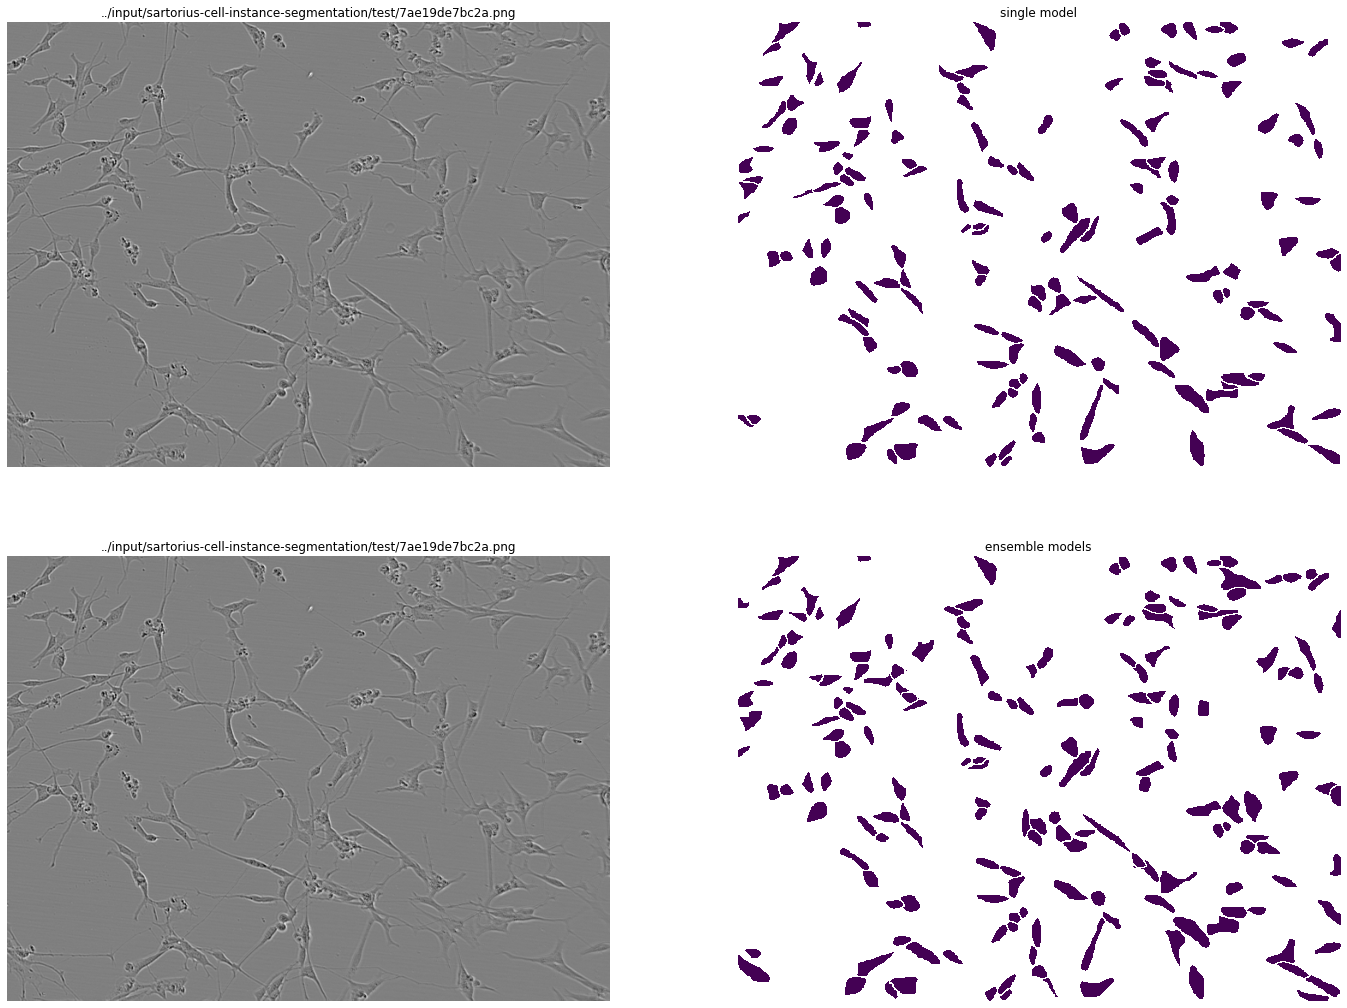

In [19]:
check_nms(model_num=0, ID_TEST=0)

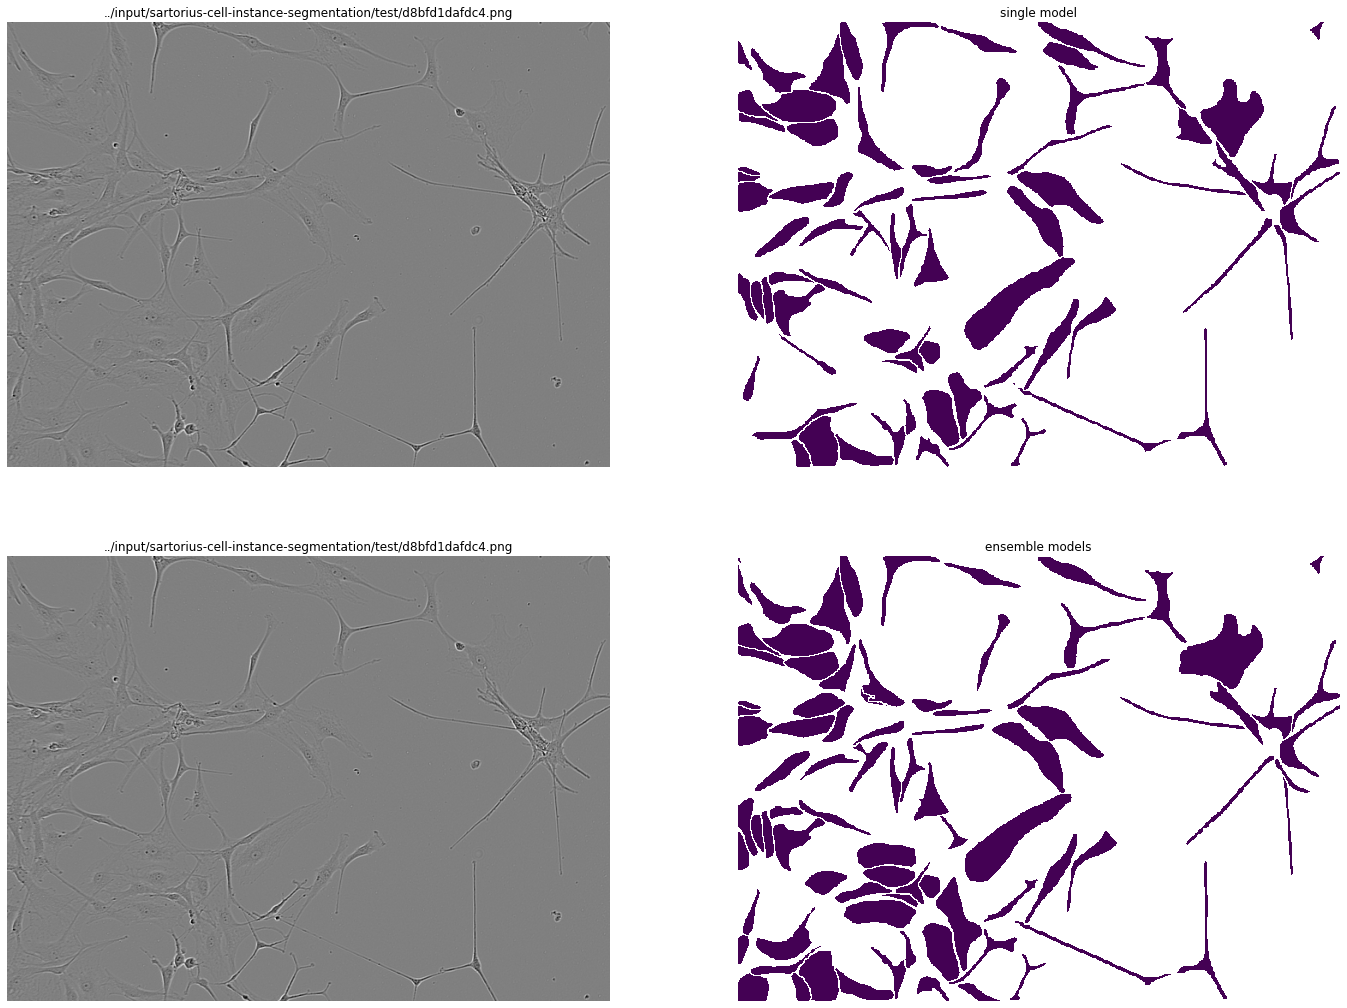

In [20]:
check_nms(model_num=0, ID_TEST=1)

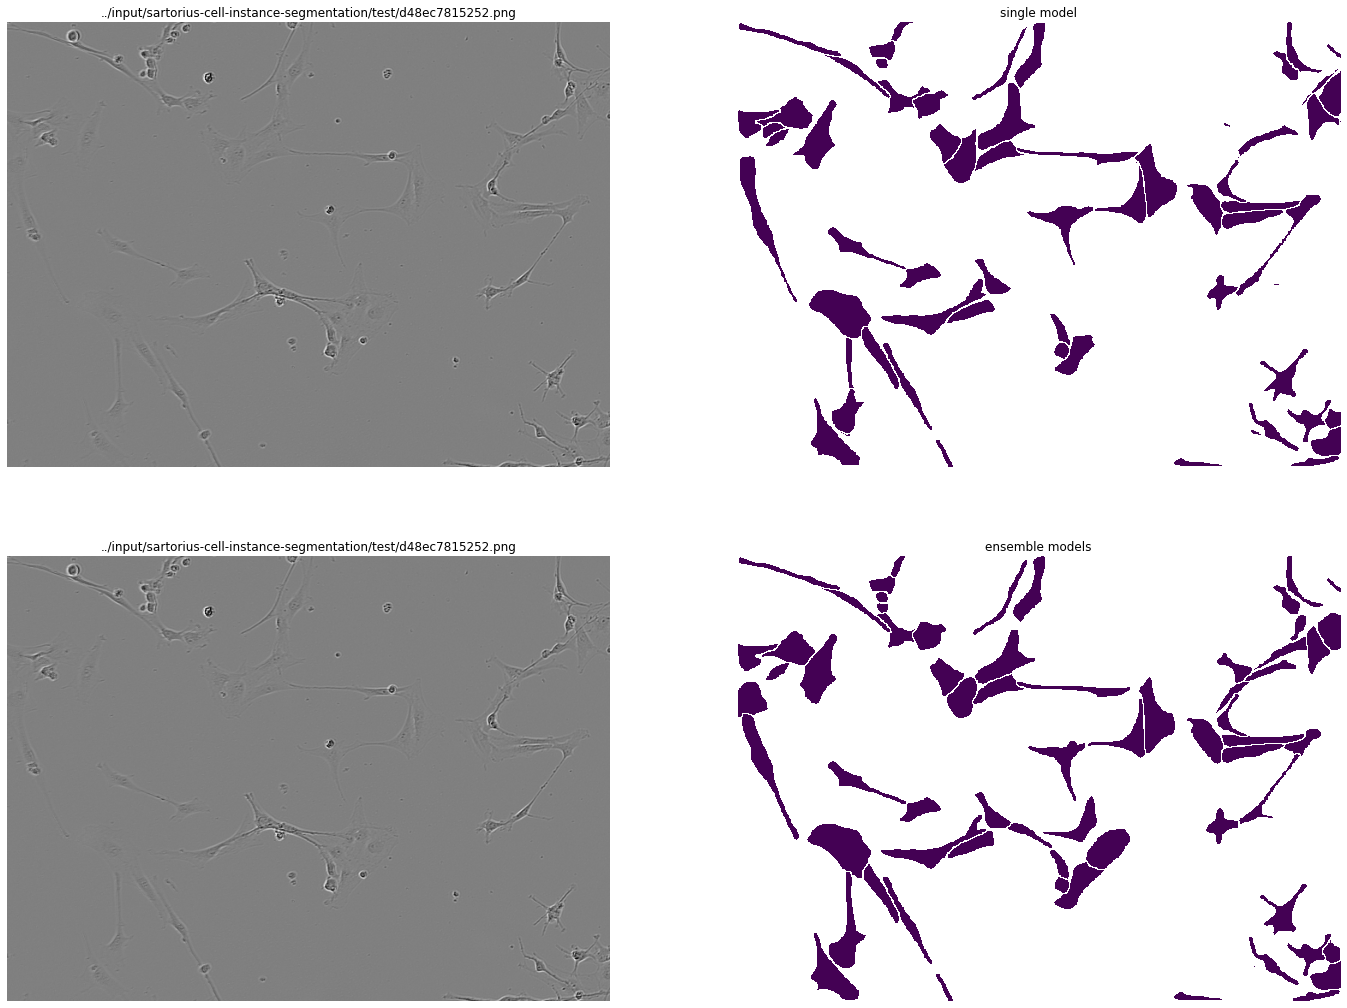

In [21]:
check_nms(model_num=0, ID_TEST=2)

# Submission

In [22]:
sub_ids = []
sub_masks = []

for file_name in test_files:
    base = os.path.basename(file_name)
    file_id = os.path.splitext(base)[0]
        
    classes, scores, bboxes, masks, model_idxs = ensemble_preds(file_name, MODELS)
    classes, scores, masks, model_idxs = nms_predictions(classes, scores, bboxes, masks, model_idxs, nms_th=NMS_TH)
    encoded_masks = ensemble_pred_masks(masks, classes, model_idxs)
        
    for enc in encoded_masks:
        sub_ids.append(file_id)
        sub_masks.append(enc)

In [23]:
df_sub = pd.DataFrame({'id': sub_ids, 'predicted': sub_masks})
df_sub.to_csv('submission.csv', index=False)
df_sub.head()

,id,predicted
0,7ae19de7bc2a,139541 4 140244 7 140948 8 141651 9 142355 10 ...
1,7ae19de7bc2a,140004 14 140706 20 141410 21 142114 21 142818...
2,7ae19de7bc2a,148931 6 149634 8 150336 11 151039 13 151742 1...
3,7ae19de7bc2a,177346 12 178043 21 178745 23 179448 25 180152...
4,7ae19de7bc2a,177490 3 178193 5 178897 5 179600 6 180303 7 1...
